In [5]:
import numpy as np
import pdr
from rich import print
import matplotlib.pyplot as plt
from scipy.stats import anderson
from astropy.visualization import ZScaleInterval
import itertools
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from PIL import Image
import cv2

In [ ]:
image_data = pdr.read('test_data/e23456/e23456-nd-ffull-b00-image-r.fits')
movie_data = pdr.read('test_data/e23456/e23456-nd-f0060-b00-movie-r.fits')
#np.shape(movie),np.shape(image)
image = image_data['COUNT']
exptime = image_data['COUNT_HEADER']['XPOSURE']
movie = movie_data['COUNT']
exptimes = [movie_data['COUNT_HEADER'][f'EXPT_{i}'] for i in range(movie_data['COUNT_HEADER']['NAXIS3'])]

100%|██████████| 29/29 [00:02<00:00, 12.11it/s]


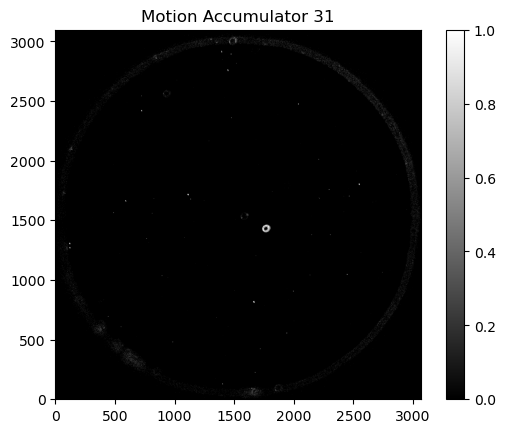

In [23]:
backSub = cv2.createBackgroundSubtractorMOG2(
    detectShadows=False,
    varThreshold=16  # Adjust for sensitivity
)
motion_accumulator = None
frame_count = 0

for frame in tqdm(movie):
    motion_mask = backSub.apply(frame)
    if motion_accumulator is None:
        motion_accumulator = motion_mask.astype(float)
    else:
        motion_accumulator += motion_mask.astype(float)

motion_accumulator /= len(movie)

plt.imshow(ZScaleInterval()(motion_accumulator), cmap='gray', origin='lower')
plt.title(f'Motion Accumulator {i}')
plt.colorbar()
plt.show();


In [ ]:
import cv2
import numpy as np

def detect_astronomical_artifacts(image_stack, 
                                 median_kernel=5,
                                 sigma_clip=2.0,
                                 min_area=3,
                                 use_morphology=True):
    """
    Detect temporal artifacts in astronomical images.
    
    Parameters:
    -----------
    image_stack : numpy.ndarray
        3D array (n_frames, height, width)
    median_kernel : int
        Kernel size for temporal median filter
    sigma_clip : float
        Standard deviations from median to flag as artifact
    min_area : int
        Minimum connected pixels to consider real artifact
    use_morphology : bool
        Apply morphological operations to clean up detections
    
    Returns:
    --------
    artifact_mask : numpy.ndarray
        2D mask where True = artifact location
    median_image : numpy.ndarray
        Clean median-combined image
    """
    
    n_frames = image_stack.shape[0]
    
    # Step 1: Create robust median image (artifact-free reference)
    # Use median for cosmic ray rejection
    median_image = np.median(image_stack, axis=0)
    
    # Step 2: Calculate median absolute deviation (MAD) for robust noise estimate
    # MAD is more robust than std for astronomical data
    deviations = np.abs(image_stack - median_image)
    mad = np.median(deviations, axis=0)
    
    # Convert MAD to equivalent standard deviation
    sigma_equivalent = 1.4826 * mad  # For Gaussian distribution
    
    # Step 3: Detect outliers in temporal direction
    artifact_accumulator = np.zeros_like(median_image)
    
    for i in range(n_frames):
        # Calculate normalized residuals
        residuals = np.abs(image_stack[i] - median_image)
        
        # Avoid division by zero
        sigma_map = np.where(sigma_equivalent > 0, sigma_equivalent, 1)
        normalized_residuals = residuals / sigma_map
        
        # Flag pixels that deviate significantly
        artifact_frame = normalized_residuals > sigma_clip
        artifact_accumulator += artifact_frame.astype(float)
    
    # Step 4: Create artifact frequency map
    artifact_frequency = artifact_accumulator / n_frames
    
    # Step 5: Apply spatial filtering to remove isolated noise
    if use_morphology:
        # Convert to uint8 for OpenCV
        artifact_binary = (artifact_frequency > 0.01).astype(np.uint8) * 255
        
        # Remove isolated pixels (likely hot pixels or noise)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        
        # Opening to remove small spots
        cleaned = cv2.morphologyEx(artifact_binary, cv2.MORPH_OPEN, kernel)
        
        # Optional: Detect linear features (satellite trails)
        edges = cv2.Canny(cleaned, 50, 150)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, 
                                minLineLength=30, maxLineGap=10)
        
        # Mark linear features
        if lines is not None:
            linear_mask = np.zeros_like(cleaned)
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(linear_mask, (x1, y1), (x2, y2), 255, 2)
            cleaned = cv2.bitwise_or(cleaned, linear_mask)
        
        artifact_mask = cleaned > 0
    else:
        artifact_mask = artifact_frequency > 0.01
    
    return artifact_mask, median_image, artifact_frequency

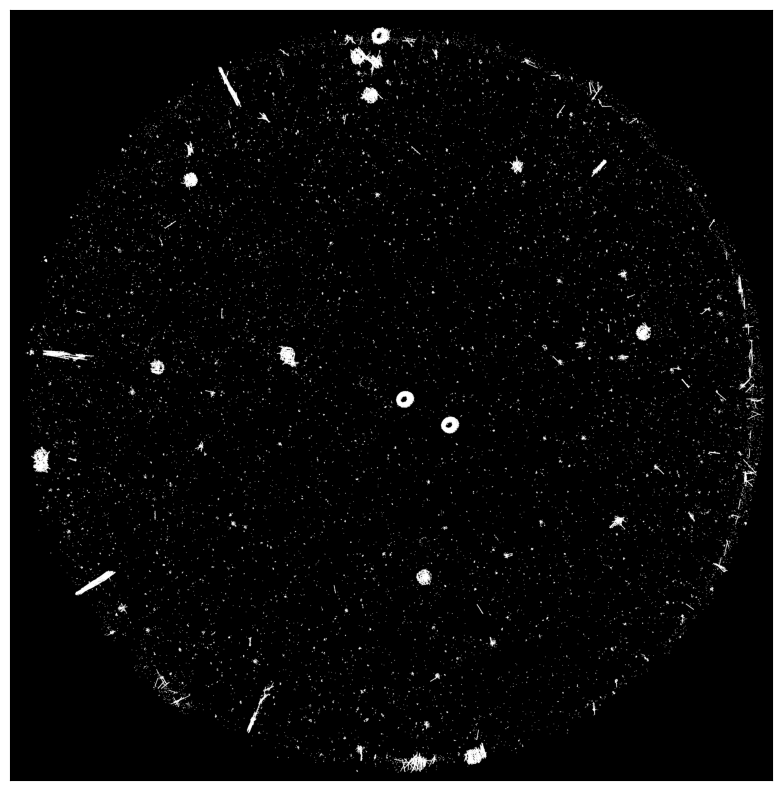

In [39]:
artifact_mask, median_image, frequency = detect_astronomical_artifacts(
    movie,
    median_kernel=5,
    sigma_clip=1.5,
    min_area=20,
    use_morphology=True
    )
plt.figure(figsize=(10,10))
plt.imshow(artifact_mask,origin='lower',cmap='gray')
plt.xticks([])
plt.yticks([]);